# Simulation setup for benchmarking matrix factorization methods

Saikat Banerjee  
2023-07-05

Simple simulation examples using different methods

# About

Here, I check if the simulation benchmarking makes sense using simple
examples. The idea is to run large scale simulations using pipelines.
Before that, I want to look at simple examples.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from nnwmf.optimize import IALM
from nnwmf.optimize import FrankWolfe_CV
from nnwmf.optimize import FrankWolfe

In [2]:
ntrait = 4 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 40 # K

In [3]:
sample_dict = mpy_simulate.get_sample_indices(ntrait, ngwas, shuffle = False)
sample_indices = [x for _, x in sample_dict.items()]
unique_labels  = [k for k, _ in sample_dict.items()]
class_labels = [None for x in range(ngwas)]
for k, x in sample_dict.items():
    for i in x:
        class_labels[i] = k

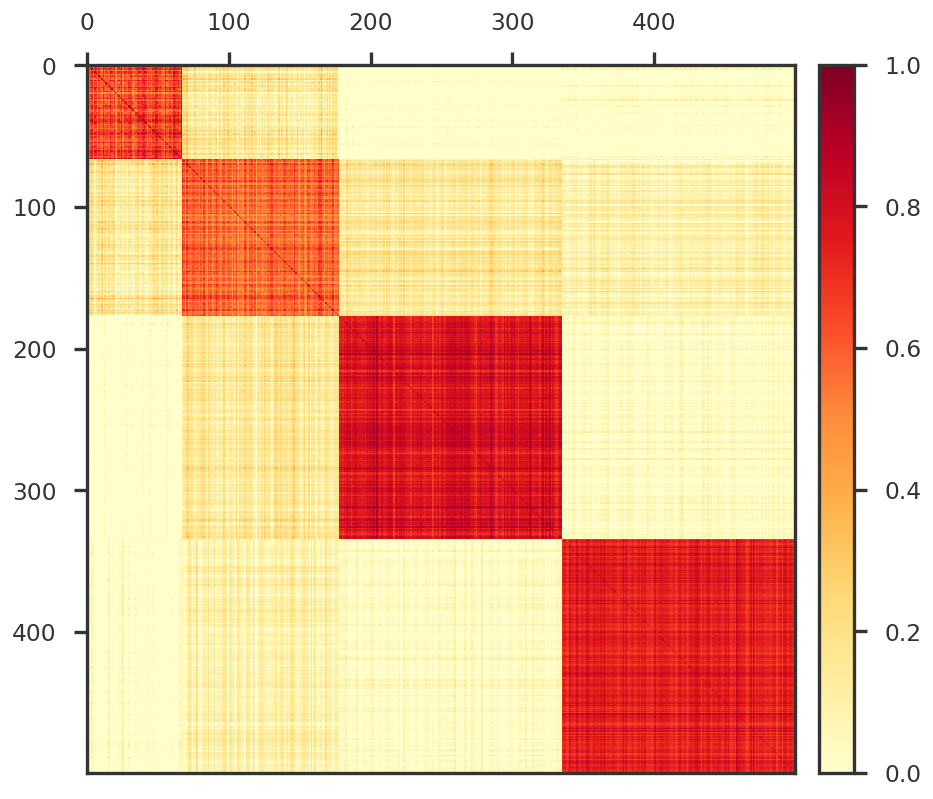

In [4]:
Y, Y_true, L, F, mean, noise_var = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, sample_groups = sample_indices, std = 1.0)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)

fig = plt.figure(figsize = (8, 8))
ax1 = fig.add_subplot(111)

mpy_plotfn.plot_covariance_heatmap(ax1, L)

plt.tight_layout()
plt.show()

# True components

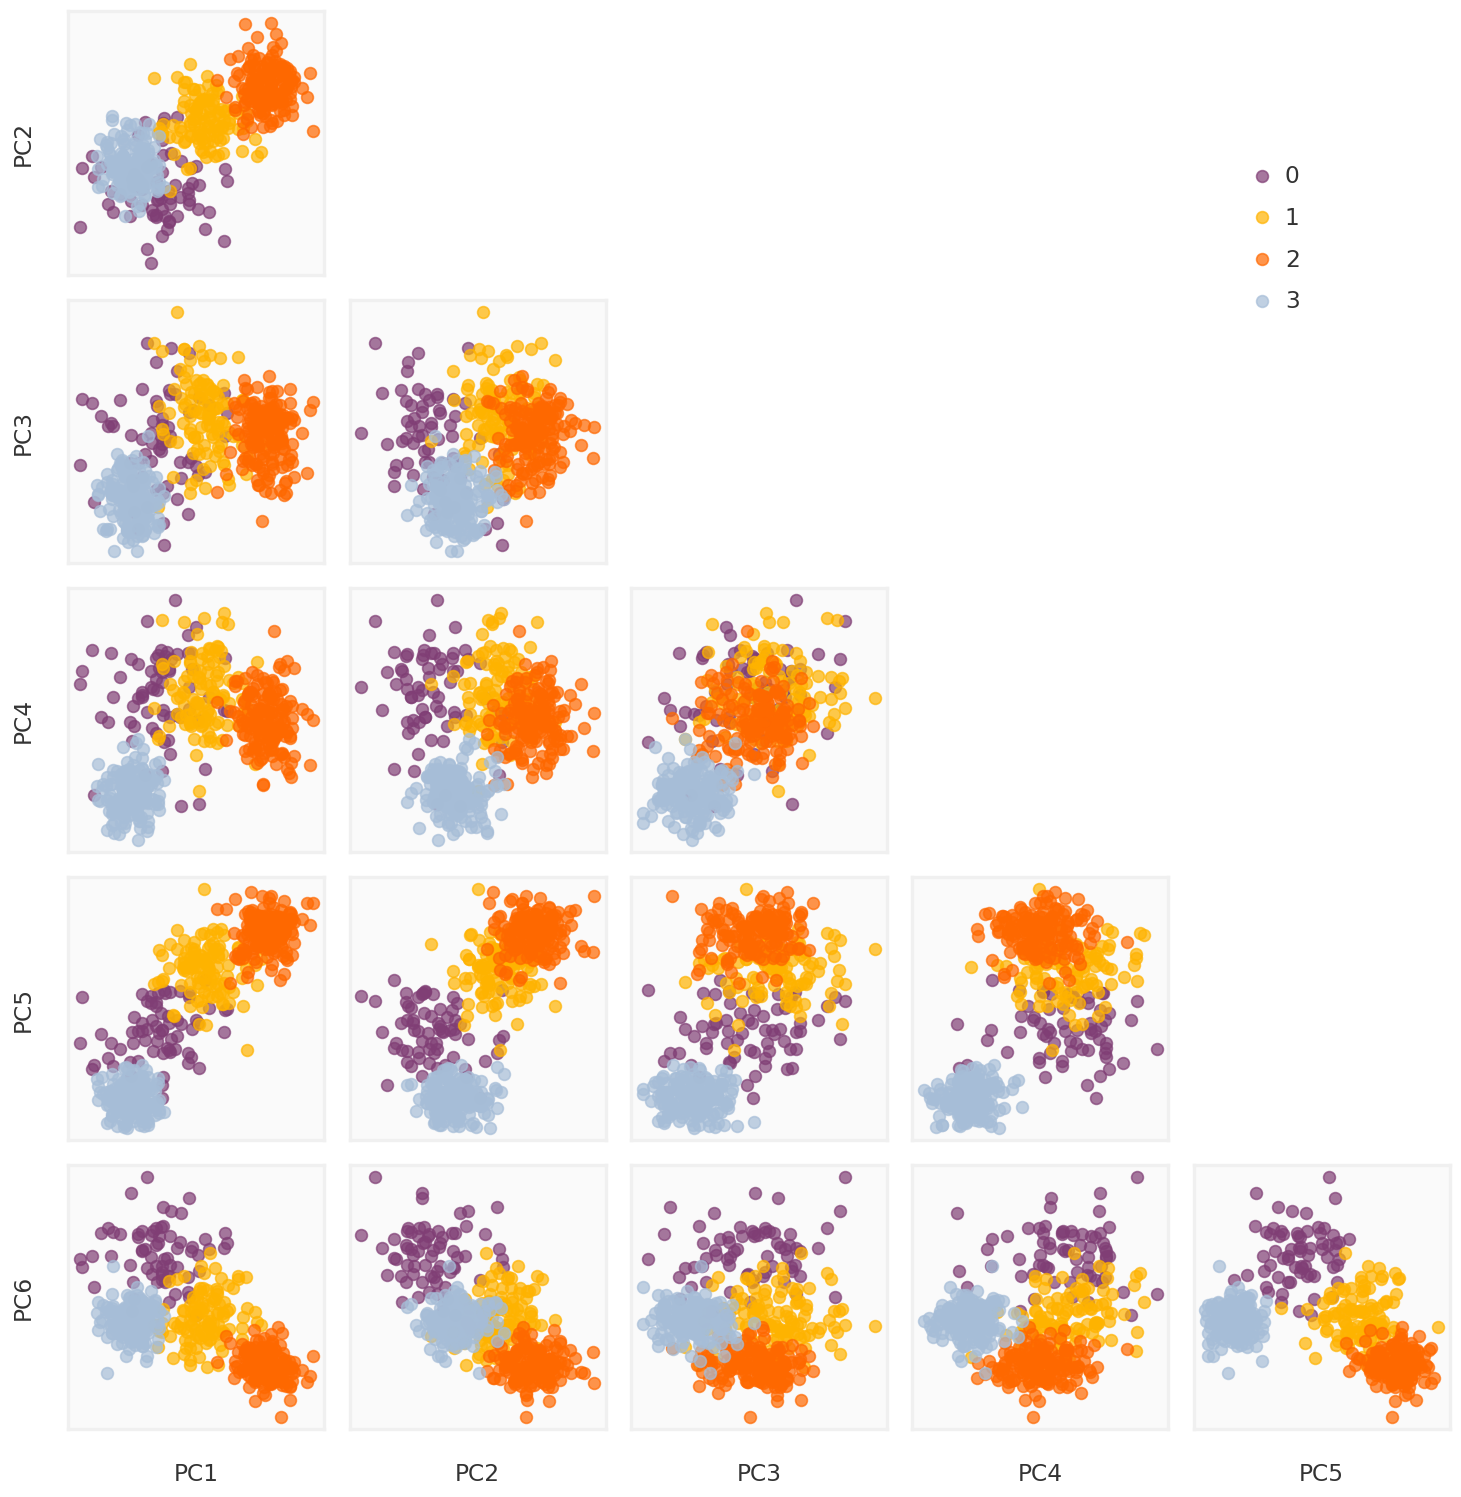

In [5]:
axmain, axs = mpy_plotfn.plot_principal_components(L, class_labels, unique_labels)
plt.show()

# Truncated SVD

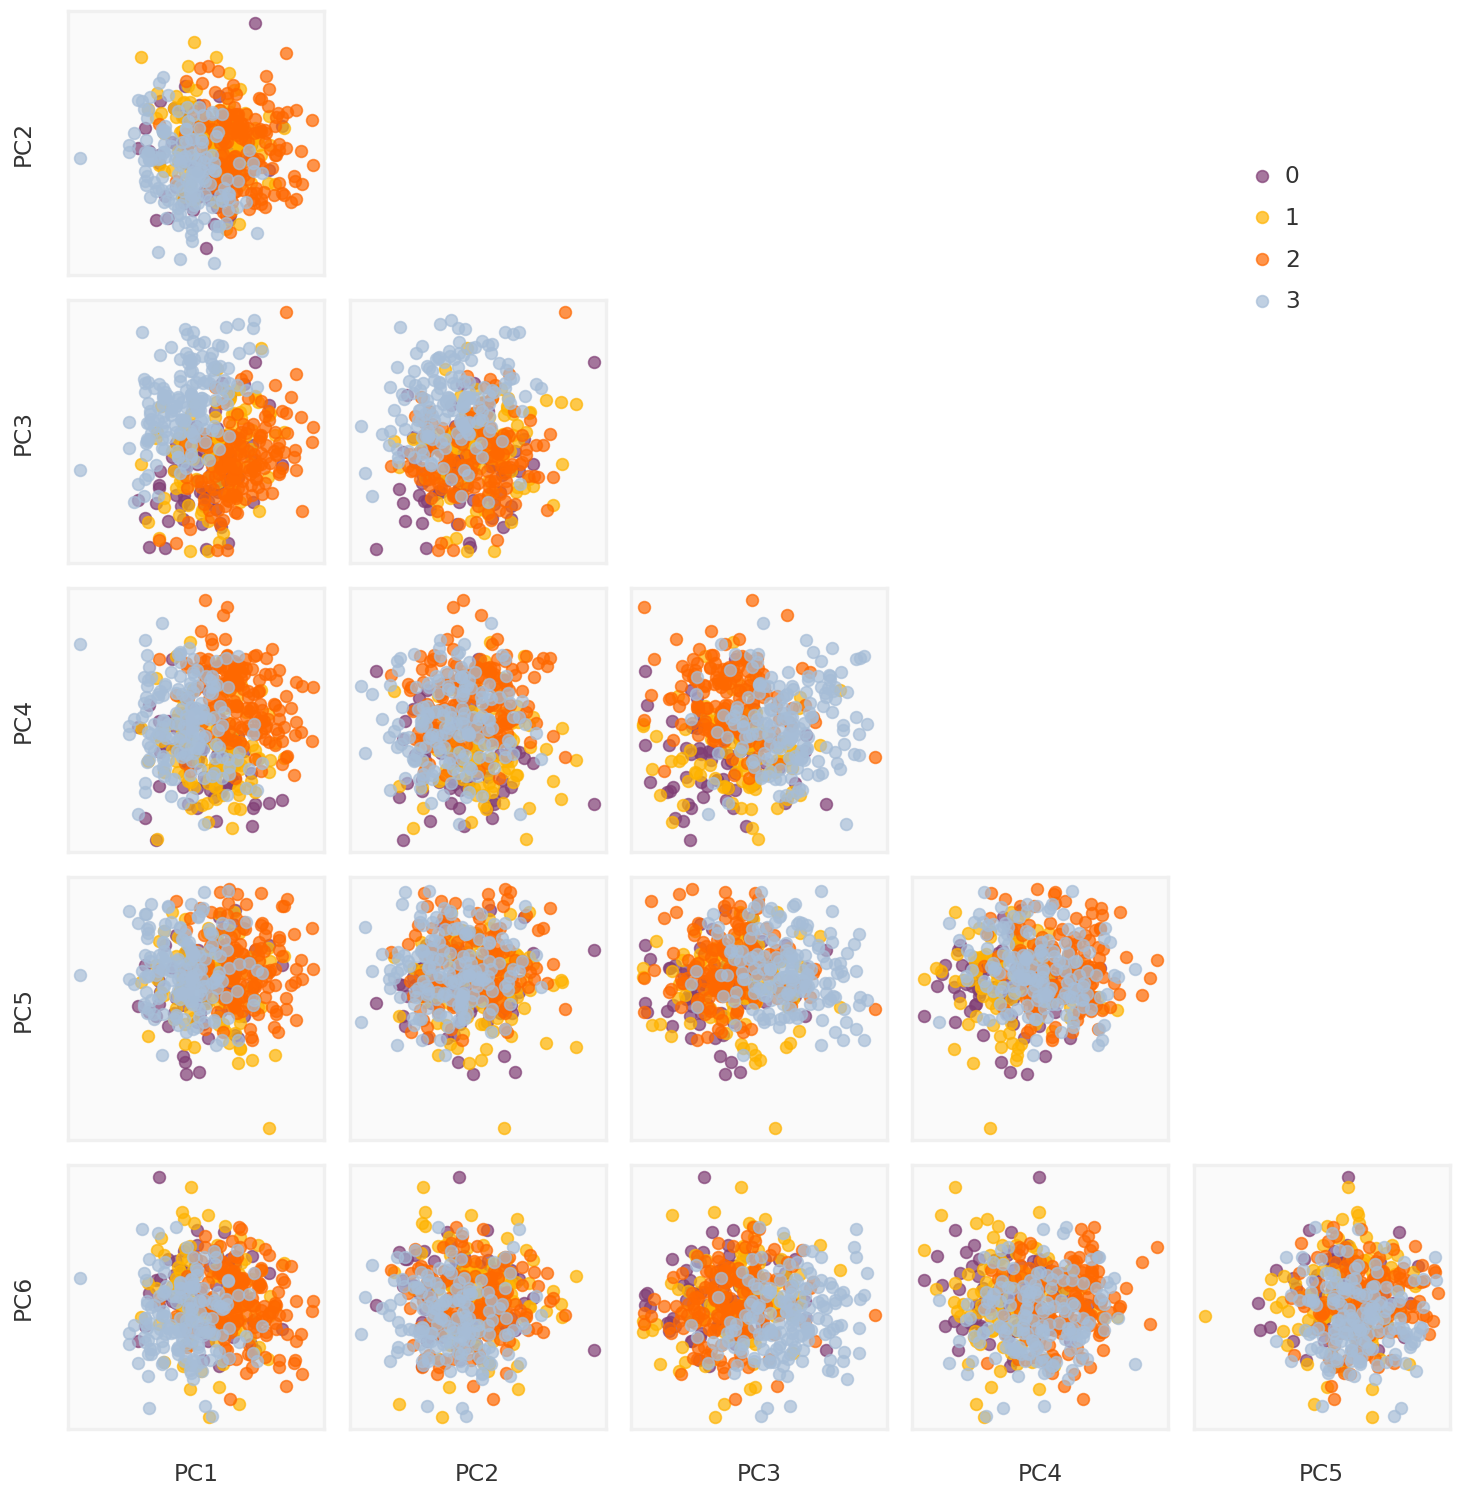

In [6]:
def truncated_SVD(X, thres = 0.9):
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    k = np.where(np.cumsum(S / np.sum(S)) >= thres)[0][0]
    pcomps = U[:, :k] @ np.diag(S[:k])
    return U, S, Vt, pcomps

_, S_tsvd, _, pcomps_tsvd = truncated_SVD(Y_cent)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_tsvd, class_labels, unique_labels)
plt.show()

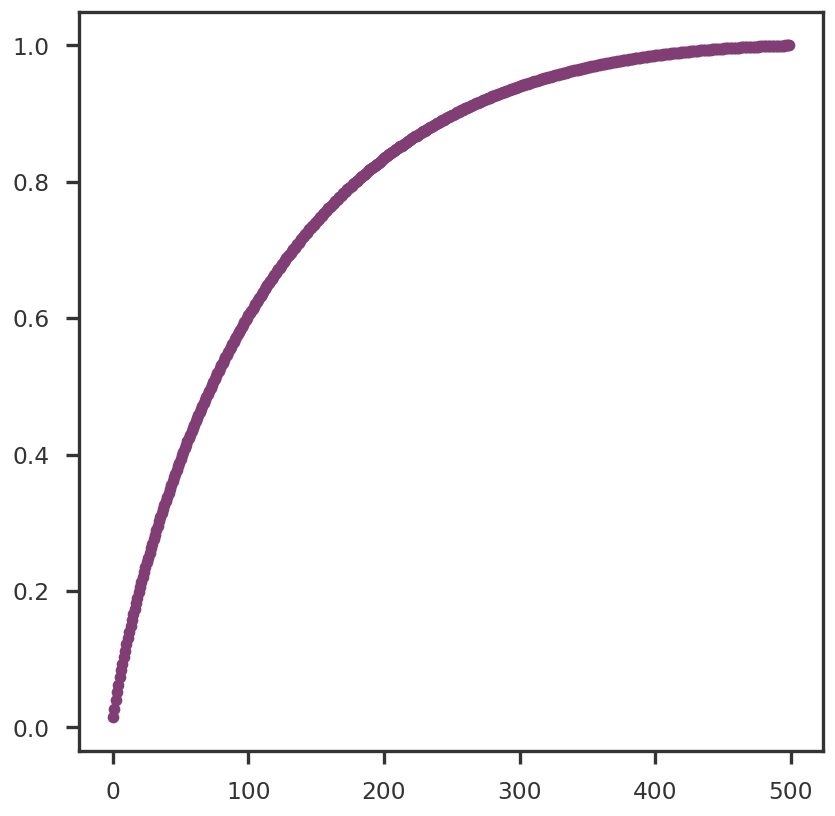

In [7]:
S2 = np.square(S_tsvd)
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(S2.shape[0]), np.cumsum(S2 / np.sum(S2)), 'o-')
plt.show()

# Nuclear Norm Minimization using Frank-Wolfe algorithm

In [8]:
nnmcv = FrankWolfe_CV(chain_init = True, reverse_path = False, kfolds = 2)
nnmcv.fit(Y_cent)

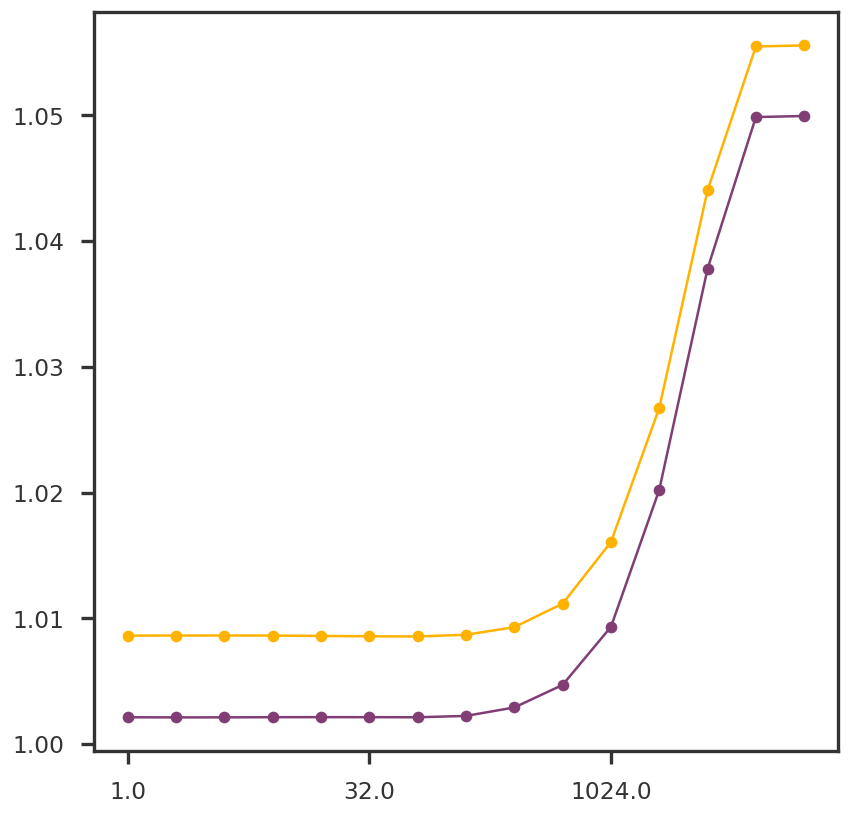

In [9]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for k in range(2):
    #ax1.plot(np.log10(list(nnmcv.training_error.keys())), [x[k] for x in nnmcv.training_error.values()], 'o-')
    ax1.plot(np.log10(list(nnmcv.test_error.keys())), [x[k] for x in nnmcv.test_error.values()], 'o-')
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
plt.show()

In [12]:
r_opt = 32.0

nnm = FrankWolfe(show_progress = True, svd_max_iter = 50, debug = True, suppress_warnings = True)
nnm.fit(Y_cent, r_opt)

Y_nnm_cent = mpy_simulate.do_standardize(nnm.X, scale = False)
U_nnm, S_nnm, Vt_nnm = np.linalg.svd(Y_nnm_cent, full_matrices = False)
pcomps_nnm = U_nnm @ np.diag(S_nnm)

2023-07-28 11:16:31,147 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 1.000. Duality Gap 2742.83

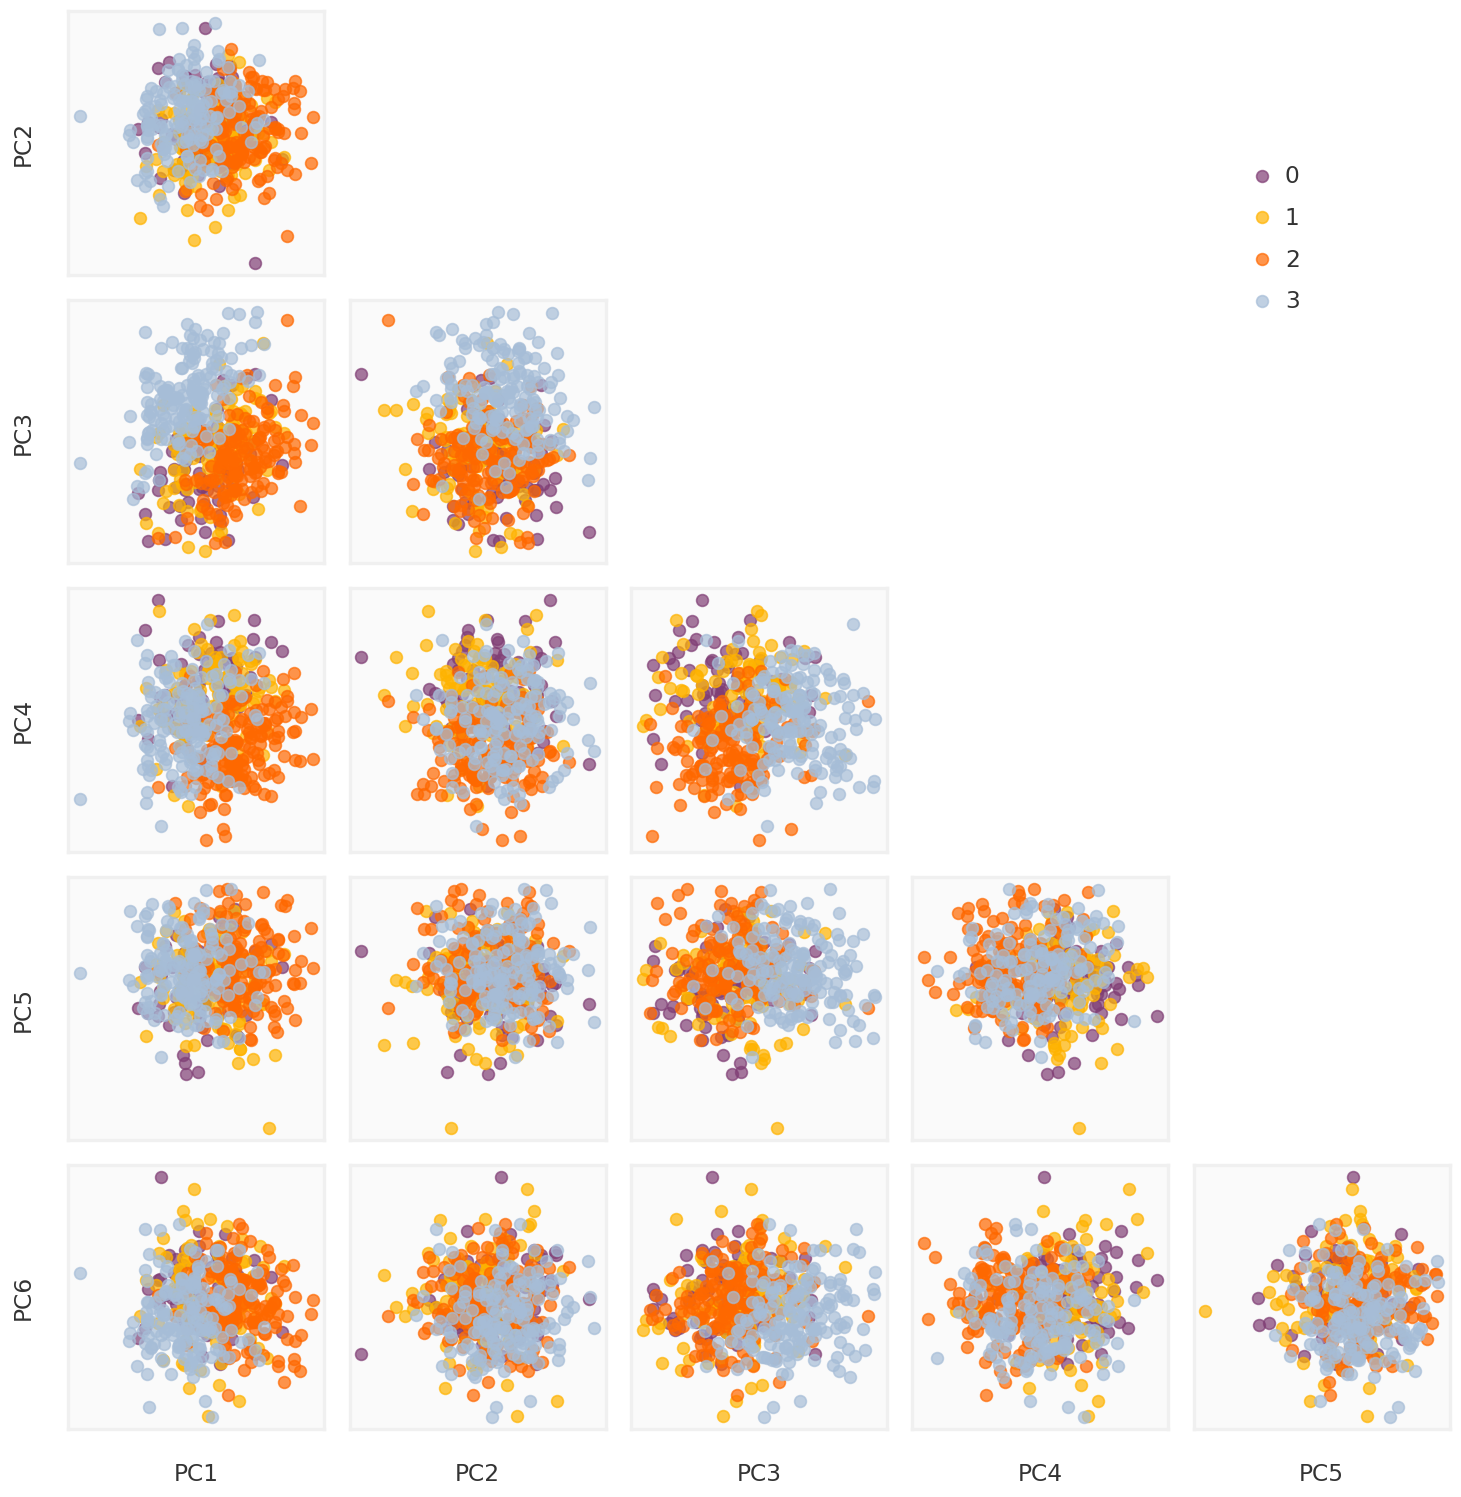

In [13]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_nnm, class_labels, unique_labels)
plt.show()

# Weighted Nuclear Norm Minimization

In [14]:
snp_weights = 1 / np.sqrt(noise_var)
weight = np.column_stack([snp_weights for _ in range(ngwas)]).T

wnnmcv = FrankWolfe_CV(chain_init = True, reverse_path = False, kfolds = 5, debug = True)
wnnmcv.fit(Y_cent, weight = weight)

2023-07-28 11:16:55,580 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Cross-validation over 15 ranks.
2023-07-28 11:16:55,604 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Fold 1 ...
2023-07-28 11:17:13,426 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Fold 2 ...
2023-07-28 11:17:35,075 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Fold 3 ...
2023-07-28 11:17:57,035 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Fold 4 ...
2023-07-28 11:18:16,387 | nnwmf.optimize.frankwolfe_cv             | DEBUG   | Fold 5 ...

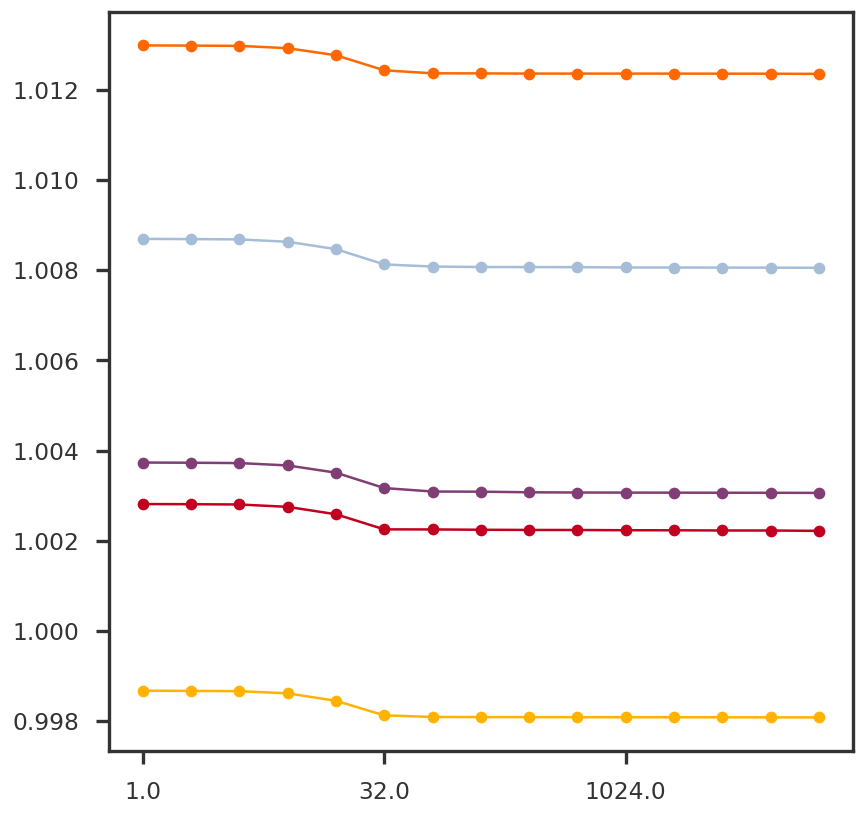

In [15]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
for k in range(5):
    #ax1.plot(np.log10(list(nnmcv.training_error.keys())), [x[k] for x in nnmcv.training_error.values()], 'o-')
    ax1.plot(np.log10(list(wnnmcv.test_error.keys())), [x[k] for x in wnnmcv.test_error.values()], 'o-')
mpl_utils.set_xticks(ax1, scale = 'log10', spacing = 'log2')
plt.show()

In [16]:
r_opt = 32.0

wnnm = FrankWolfe(show_progress = True, svd_max_iter = 50, debug = True)
wnnm.fit(Y_cent, r_opt, weight = weight)

Y_wnnm_cent = mpy_simulate.do_standardize(wnnm.X, scale = False)
U_wnnm, S_wnnm, Vt_wnnm = np.linalg.svd(Y_wnnm_cent, full_matrices = False)
pcomps_wnnm = U_wnnm @ np.diag(S_wnnm)

2023-07-28 11:18:52,909 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 0. Step size 0.154. Duality Gap 7.2392e+06
2023-07-28 11:18:55,519 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 100. Step size 0.003. Duality Gap 100806
2023-07-28 11:18:58,015 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 200. Step size 0.003. Duality Gap 42452.7
2023-07-28 11:19:00,500 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 300. Step size 0.002. Duality Gap 31460.9
2023-07-28 11:19:02,997 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 400. Step size 0.005. Duality Gap 20861.9
2023-07-28 11:19:05,500 | nnwmf.optimize.frankwolfe                | INFO    | Iteration 500. Step size 0.004. Duality Gap 16232.8

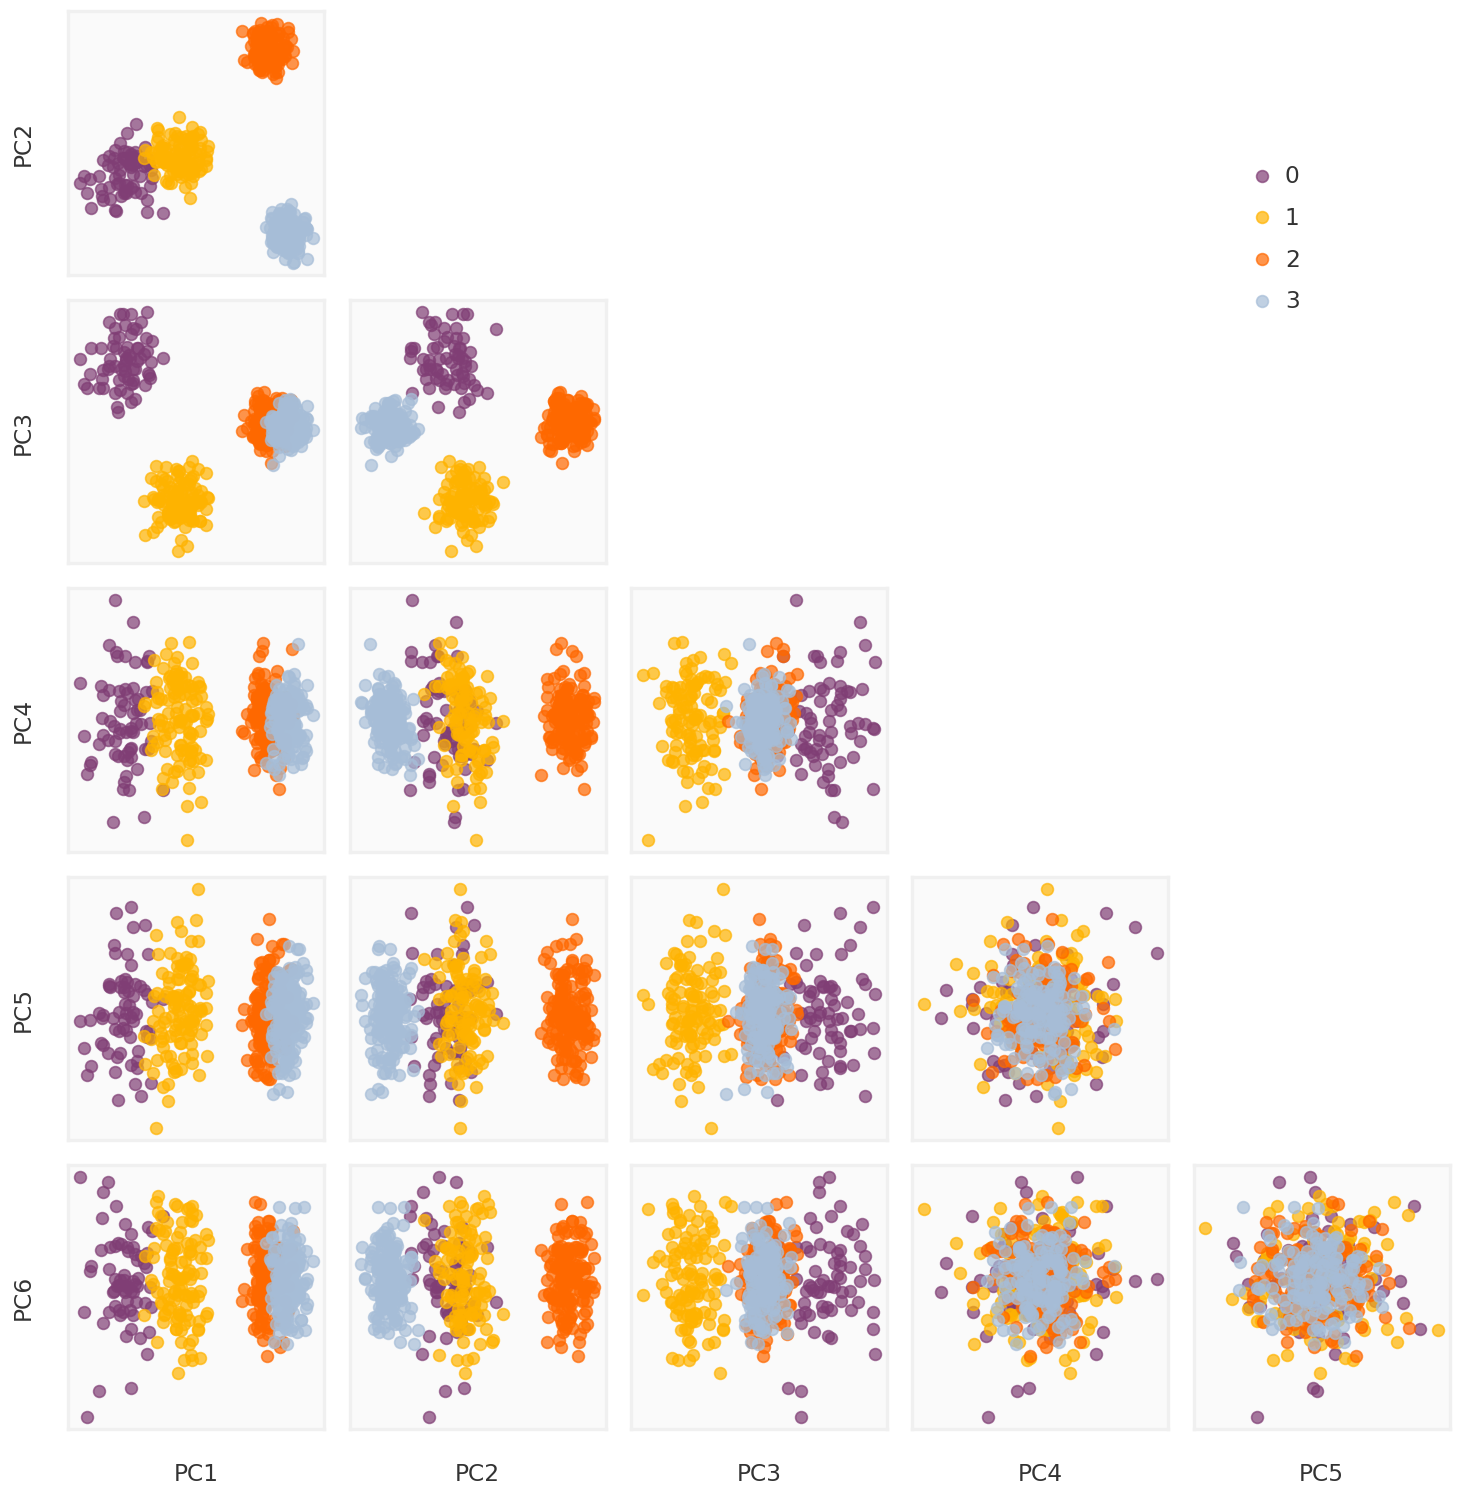

In [17]:
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_wnnm, class_labels, unique_labels)
plt.show()

# Robust PCA

In [18]:
rpca = IALM()
rpca.fit(Y_cent)
np.linalg.matrix_rank(rpca.L_)

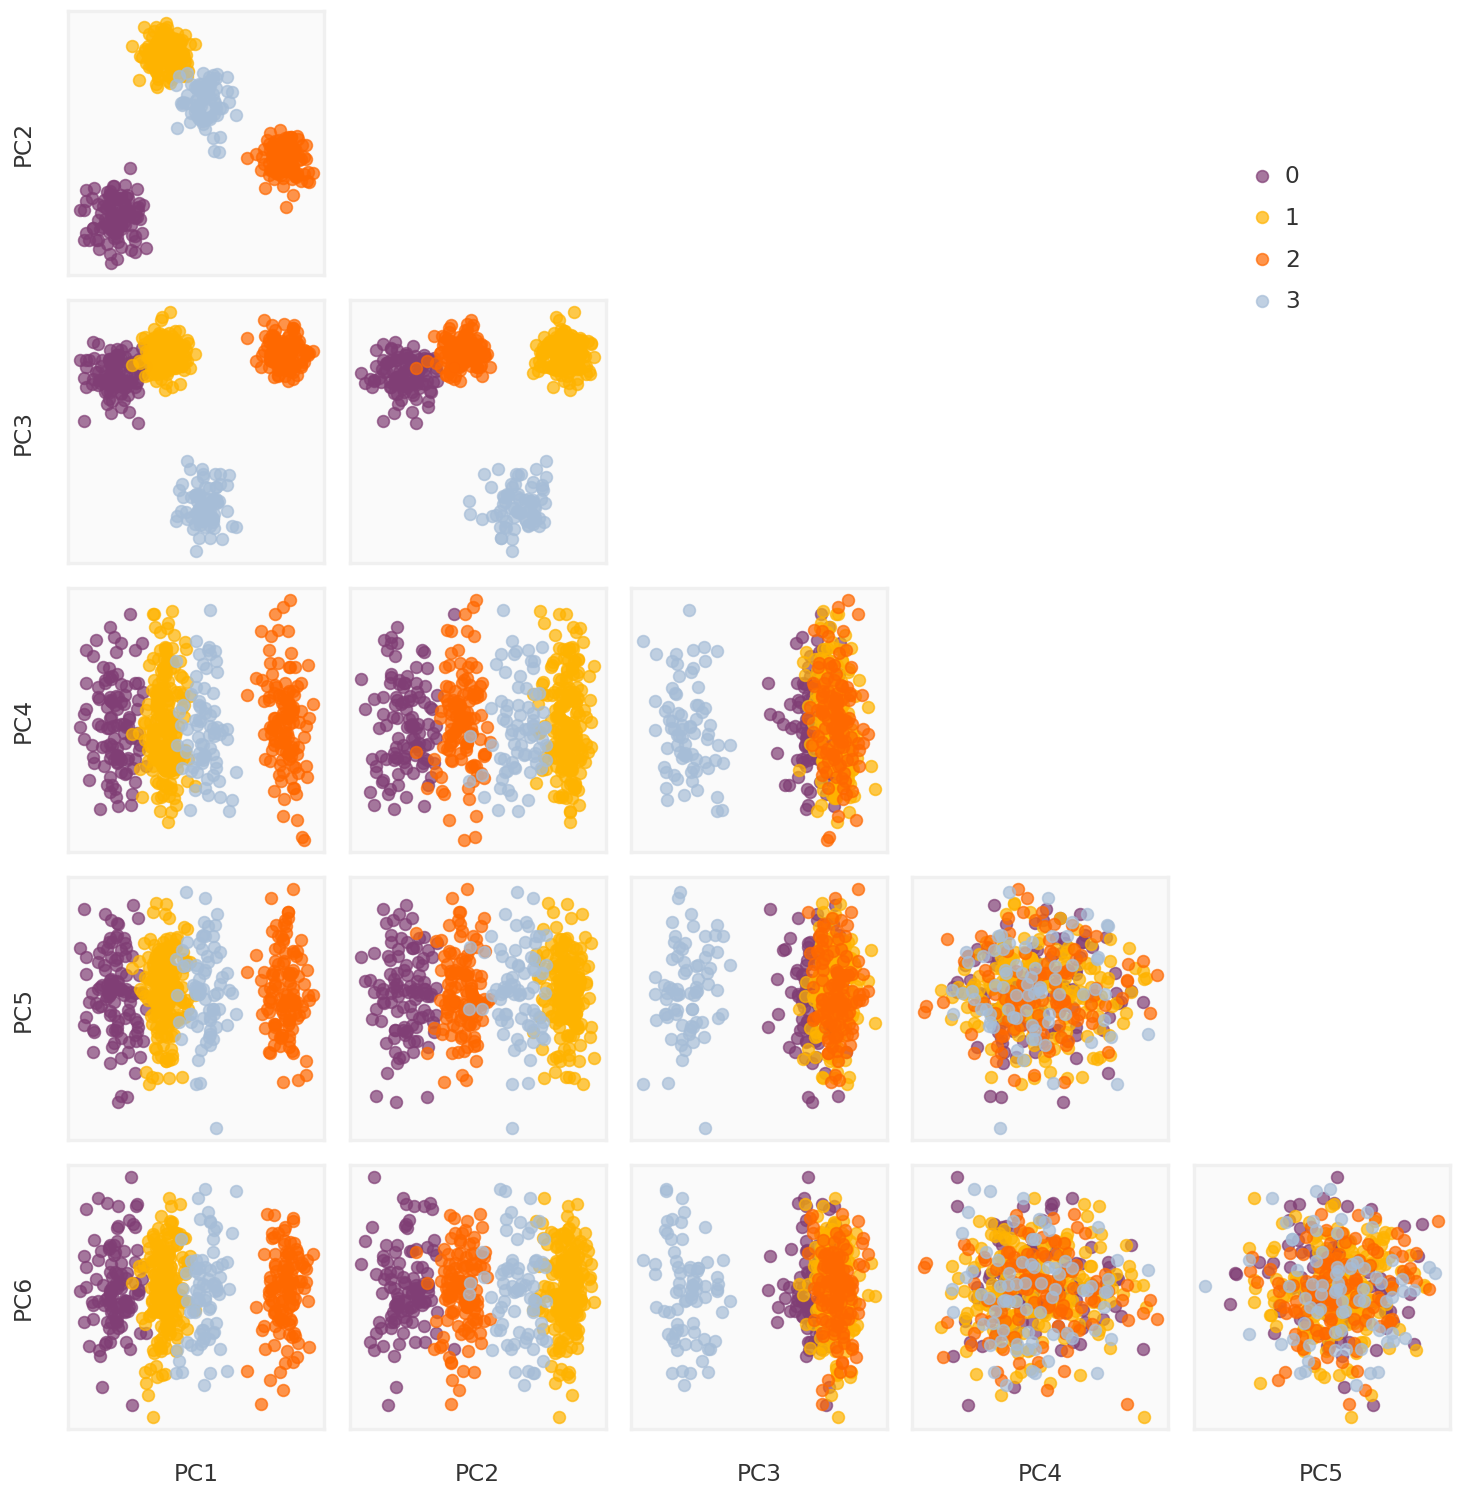

In [29]:
Y_rpca_cent = mpy_simulate.do_standardize(L_rpca, scale = False)
U_rpca, S_rpca, Vt_rpca = np.linalg.svd(Y_rpca_cent, full_matrices = False)
pcomps_rpca = U_rpca @ np.diag(S_rpca)
axmain, axs = mpy_plotfn.plot_principal_components(pcomps_rpca, class_labels, unique_labels)
plt.show()

In [30]:
def get_rmse(original, recovered, mask = None):
    if mask is None:
        mask = np.ones(original.shape)
    n = np.sum(mask)
    mse = np.sum(np.square((original - recovered) * mask)) / n
    return np.sqrt(mse)
    
Y_true_cent = mpy_simulate.do_standardize(Y_true, scale = False)
Y_rpca_cent = mpy_simulate.do_standardize(L_rpca, scale = False)

rmse_nnm = get_rmse(Y_true_cent, Y_nnm_cent)
rmse_wnnm = get_rmse(Y_true_cent, Y_wnnm_cent)
rmse_rpca = get_rmse(Y_true_cent, Y_rpca_cent)

print (f"{rmse_nnm:.4f}\tNuclear Norm Minimization")
print (f"{rmse_wnnm:.4f}\tWeighted Nuclear Norm Minimization")
print (f"{rmse_rpca:.4f}\tRobust PCA")

0.1448  Nuclear Norm Minimization
0.1427  Weighted Nuclear Norm Minimization
0.1054  Robust PCA

In [31]:
def get_psnr(original, recovered):
    n, p = original.shape
    maxsig2 = np.square(np.max(original) - np.min(original))
    mse = np.sum(np.square(recovered - original)) / (n * p)
    res = 10 * np.log10(maxsig2 / mse)
    return res

psnr_nnm = get_psnr(Y_true_cent, Y_nnm_cent)
psnr_wnnm = get_psnr(Y_true_cent, Y_wnnm_cent)
psnr_rpca = get_psnr(Y_true_cent, Y_rpca_cent)

print (f"{psnr_nnm:.4f}\tNuclear Norm Minimization")
print (f"{psnr_wnnm:.4f}\tWeighted Nuclear Norm Minimization")
print (f"{psnr_rpca:.4f}\tRobust PCA")

21.2372 Nuclear Norm Minimization
21.3642 Weighted Nuclear Norm Minimization
23.9949 Robust PCA

In [32]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics as skmetrics

def get_adjusted_MI_score(pcomp, class_labels):
    distance_matrix = skmetrics.pairwise.pairwise_distances(pcomp, metric='euclidean')
    model = AgglomerativeClustering(n_clusters = 4, linkage = 'average', metric = 'precomputed')
    class_pred = model.fit_predict(distance_matrix)
    return skmetrics.adjusted_mutual_info_score(class_labels, class_pred)

adjusted_mi_nnm = get_adjusted_MI_score(pcomps_nnm,   class_labels)
adjusted_mi_wnnm = get_adjusted_MI_score(pcomps_wnnm, class_labels)
adjusted_mi_rpca = get_adjusted_MI_score(pcomps_rpca, class_labels)

print (f"{adjusted_mi_nnm:.4f}\tNuclear Norm Minimization")
print (f"{adjusted_mi_wnnm:.4f}\tWeighted Nuclear Norm Minimization")
print (f"{adjusted_mi_rpca:.4f}\tRobust PCA")

-0.0006 Nuclear Norm Minimization
1.0000  Weighted Nuclear Norm Minimization
1.0000  Robust PCA